In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from tabulate import tabulate


from src.train import train, test
from src.models import Simple3BlockCNN, BNDropout3BlockCNN, AIDetectorResNet, SimpleResNetCNN
from src.utils import split_data, print_history

Using device: mps


# AI Detection

In [5]:
FREEZE_BACKBONE = True
DROPOUT_RATE = 0.7

BATCH_SIZE = 32
TRAIN_SIZE = 0.8
EPOCHS = 30
LEARNING_RATE = 1e-4
PATIENCE = 5

train_loader, val_loader, test_loader = split_data(root_dir="data/ai-images", batch_size=BATCH_SIZE)

           Train    Val    Test    Total
-------  -------  -----  ------  -------
Samples      754     94      96      944
Batches       24      3       3       30


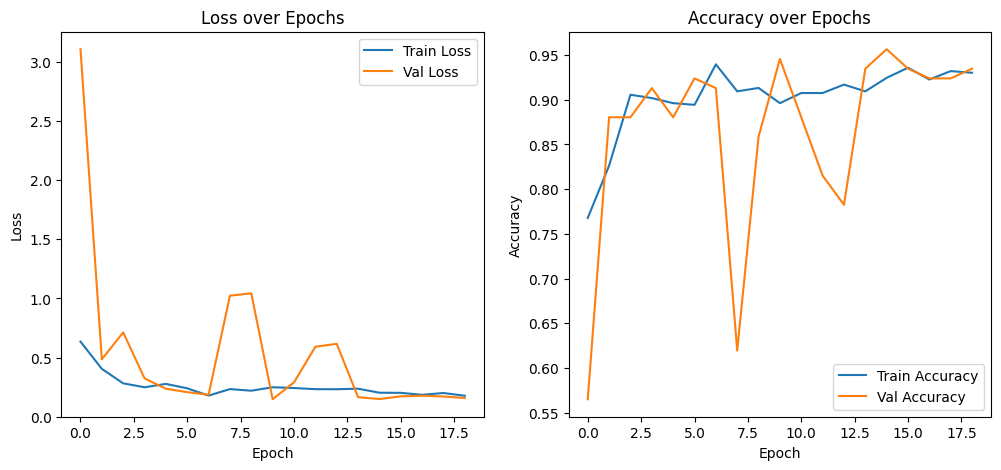

Epoch 19/30
  Train Loss: 0.1763, Train Acc: 0.9302
  Val   Loss: 0.1570, Val   Acc: 0.9348
  Best Val Acc: 0.9565 at Epoch 15
  Learning Rate: 0.000001


Early stopping at epoch 20
History saved to models/AIDetectorResNet/run_2/history.json


In [8]:
model = AIDetectorResNet(
    freeze_backbone=FREEZE_BACKBONE,
    dropout_rate=DROPOUT_RATE
)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.backbone.fc.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

history = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    patience=PATIENCE
)

# Testing

In [3]:
model = AIDetectorResNet()
model_path = "models/AIDetectorResNet/run_1/best_model.pth"
model.load_state_dict(torch.load(model_path))

criterion = nn.BCEWithLogitsLoss()

test_result = test(model=model,
                   test_loader=test_loader,
                   criterion=criterion)

/Users/tsigall/repositories/WatchdogAI/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tsigall/repositories/WatchdogAI/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
table_data = [
    ["AIDetectorResNet", round(test_result[0], 3), test_result[1]]
]

headers = ["Model", "Loss", "Accuracy"]

print(tabulate(table_data, headers=headers))

Model               Loss    Accuracy
----------------  ------  ----------
AIDetectorResNet   0.157        0.95


In [4]:
# move images
import os
import shutil
import random

# Set up paths
raw_data_dir = "data/raw-data"
output_base = "data/ai-images"
train_dir = os.path.join(output_base, "train", "true")
val_dir = os.path.join(output_base, "val", "true")
test_dir = os.path.join(output_base, "test", "true")

# Get all image files
image_files = [f for f in os.listdir(raw_data_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
random.shuffle(image_files)

# Calculate split indices
total = len(image_files)
train_end = int(total * 0.8)
val_end = train_end + int(total * 0.1)

# Split files
train_files = image_files[:train_end]
val_files = image_files[train_end:val_end]
test_files = image_files[val_end:]

# Move files to respective directories
for file in train_files:
    shutil.copy2(os.path.join(raw_data_dir, file), os.path.join(train_dir, file))
for file in val_files:
    shutil.copy2(os.path.join(raw_data_dir, file), os.path.join(val_dir, file))
for file in test_files:
    shutil.copy2(os.path.join(raw_data_dir, file), os.path.join(test_dir, file))

print(f"Moved {len(train_files)} files to train, {len(val_files)} to val, and {len(test_files)} to test")

Moved 377 files to train, 47 to val, and 48 to test
